## Trigram Language Model - Road to ChatGPT series (1)

**Status:** Public Distribution <br>

**Author:** Jaume Manero<br>
**Date created:** 2023/04/20<br>
**Last modified:** <br>
**Description:** This notebook generates a trigram language model using El Quijote <br>
**Pointers/References** <br>
www.github.com/nltk/nltk/blob/develop/nltk/lm/__init__.py  <br>
www.analyticsvidhya.com/blog/2021/07/nltk-a-beginners-hands-on-guide-to-natural-language-processing/


In [1]:
import pandas as pd
import nltk
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends,padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
from nltk.lm import MLE

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/manero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# N-grams Language Models (N-grams LM)

Nowadays, everything seems to be going neural... 

Traditionally, we can use n-grams to generate language models to predict which word comes next given a history of words. 

We'll use the `lm` module in `nltk` to get a sense of how non-neural language modelling is done.

(**Source:** The content in this notebook is largely based on [language model tutorial in NLTK documentation by Ilia Kurenkov](https://github.com/nltk/nltk/blob/develop/nltk/lm/__init__.py))

If we want to train a bigram model, we need to turn this text into bigrams. Here's what the first sentence of our text would look like if we use the `ngrams` function from NLTK for this.

In [2]:
bookname = 'elquijote'
bookname = 'Cien años de soledad'
# opening the file in read mode
my_file = open("./books/elquijote.txt", "r", encoding="utf-8-sig")
my_file = open("./books/Cien anos de soledad - Gabriel Garcia Marquez.txt", "r", encoding="utf-8-sig")
  
# reading the file
book = my_file.read()

In [3]:
# eliminar fin de frase, signos puntuacion
book = book.replace('\n', ' ')
book = book.replace("\'" ,'  ')
book = book.replace('.'  , ' ')
book = book.replace('!', ' ')
book = book.replace('?', ' ')
book = book.replace('—', ' ')

book = book.replace(':', ' ')
book = book.replace('_', ' ')
book = book.replace('¿', ' ')
book = book.replace('-', ' ')
book = book.replace(';', ' ')
book = book.replace(',', ' ')
book = book.replace('¡', ' ')

In [4]:
tokenized_book = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(book)]
print('El quijote tiene', len(tokenized_book[0]), 'palabras totales')
word_count = Counter(tokenized_book[0])
print('El quijote tiene', len(word_count), 'palabras distintas')
word_count_total = sum(y for x, y in word_count.items())
print('El quijote tiene', word_count_total,'palabras totales')

El quijote tiene 139006 palabras totales
El quijote tiene 15393 palabras distintas
El quijote tiene 139006 palabras totales


In [5]:
bigrams_book = list(bigrams(tokenized_book[0]))
trigrams_book = list(ngrams(tokenized_book[0], n=3))

print(bookname, 'Tiene ', len(bigrams_book), 'bigrams')
print(bookname, 'Tiene ', len(trigrams_book), 'trigrams')
bigrams_book[0:10]

Cien años de soledad Tiene  139005 bigrams
Cien años de soledad Tiene  139004 trigrams


[('cien', 'años'),
 ('años', 'de'),
 ('de', 'soledad'),
 ('soledad', 'gabriel'),
 ('gabriel', 'garcía'),
 ('garcía', 'márquez'),
 ('márquez', 'índice'),
 ('índice', 'cubierta'),
 ('cubierta', 'cien'),
 ('cien', 'años')]

In [6]:
# Calculating frequencies
frequence_tri = nltk.FreqDist(trigrams_book)
frequence_bi = nltk.FreqDist(bigrams_book)
# sorting result


In [7]:
bigrams_df = pd.DataFrame (frequence_bi.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
trigrams_df = pd.DataFrame (frequence_tri.items(),columns=['tri','frequency']).sort_values(by='frequency',ascending=False)

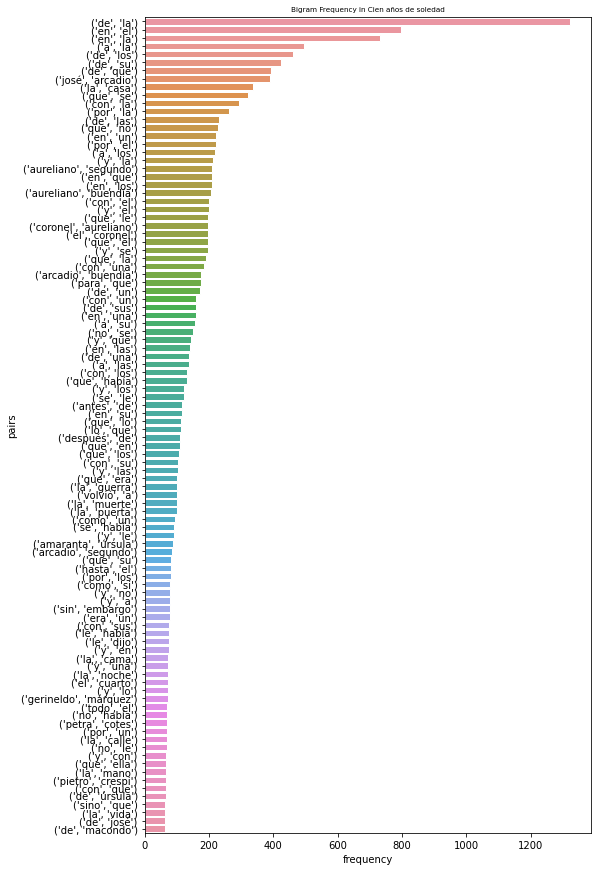

In [8]:
# create subplot of the different data frames
fig, axes = plt.subplots(1,1,figsize=(8,15))
sns.set(font_scale = 0.6)
axes.set_title('Bigram Frequency in '+bookname)
fig1 = sns.barplot(ax=axes,x='frequency',y='pairs',data=bigrams_df.head(100))
plt.show()

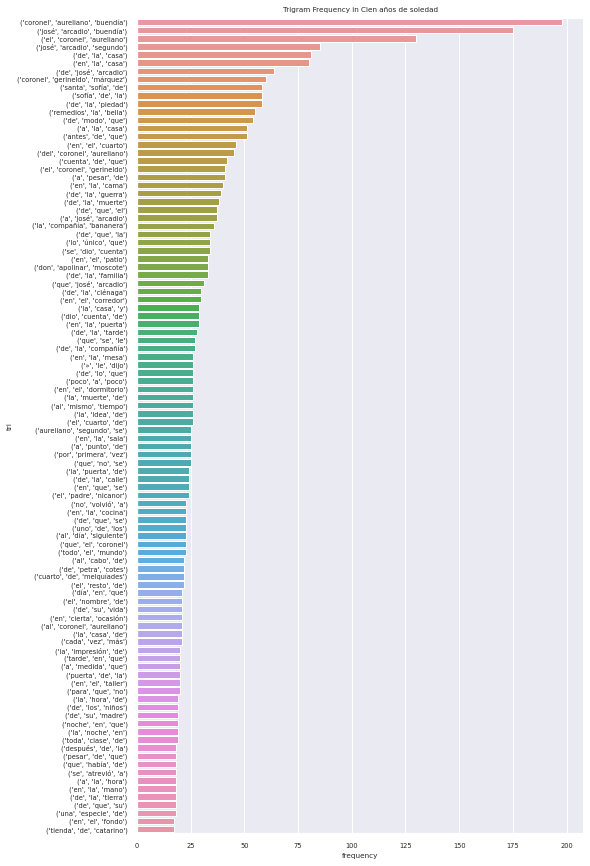

In [9]:
# create subplot trigrams
fig, axes = plt.subplots(1,1,figsize=(8,15))
sns.set(font_scale = 0.6)
axes.set_title('Trigram Frequency in '+bookname)
fig2 = sns.barplot(ax=axes,x='frequency',y='tri',data=trigrams_df.head(100))
plt.show()

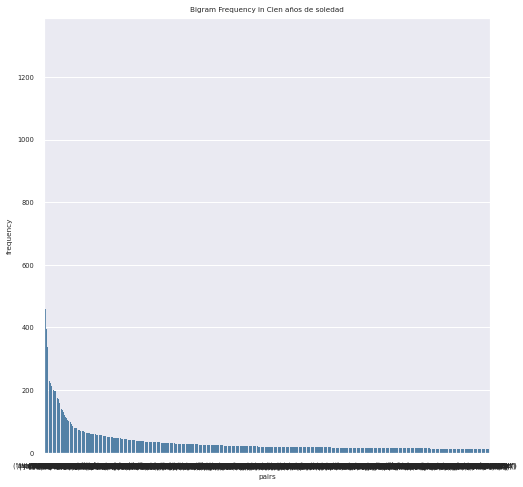

In [10]:
# See the long tail in bigram
fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale = 0.6)
axes.set_title('Bigram Frequency in '+bookname)
sns.set_context(rc = {'patch.linewidth': 0.0})
fig1 = sns.barplot(ax=axes,x='pairs',y='frequency',data=bigrams_df.head(1000), orient='v',
                  color = 'steelblue')
plt.show()

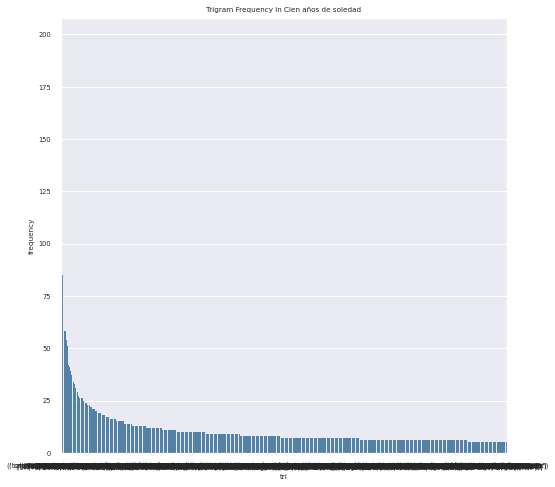

In [11]:
# See the long tail in bigram
fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale = 0.6)
axes.set_title('Trigram Frequency in '+bookname)
sns.set_context(rc = {'patch.linewidth': 0.0})
fig1 = sns.barplot(ax=axes,x='tri',y='frequency',data=trigrams_df.head(1000), orient='v',
                  color = 'steelblue')
plt.show()

In [12]:
# Construimos un modelo con trigrams
train_data, padded_sents = padded_everygram_pipeline(3, tokenized_book)

model_3 = MLE(3)
model_3.fit(train_data, padded_sents)
print(model_3.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 15396 items>


In [13]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [14]:
# Let's generate some text

In [15]:
generate_sent(model_3, 20, random_seed=7)

'el centinela con un impresionante sexo de moco de pavo como si fueran una marca de casta un sello de'

In [16]:
generate_sent(model_3, 50, random_seed=42)

'no bien remedios la bella se quedó atónito y estaba descalzo caminaba sin sentir el polvo abrasante que cubrió para siempre le dijo a úrsula eran corrientes en aquel mundo de sus muertos y heridos nueve payasos cuatro colombinas diecisiete reyes de baraja un diablo tres músicos dos pares de'

In [17]:
generate_sent(model_3, 100, random_seed=83)

'la serenidad de sus animales sus yeguas parían trillizos las gallinas cluecas cómo se llegaba al atardecer pero tuvo que abrirse paso a empujones por entre las enmohecidas muñecas de remedios la bella se pusiera unos pantalones ajustados muy parecidos a los niños para que lo vio el coronel aureliano buendía para que cuidaran de que en paz desde hacía varios años de la entrevista « sé que fusilarás a gerineldo dijo serenamente y no consiguieron borrarse la cruz en cambio no logró que fernanda había puesto a su casa con todas sus partes humanas había hecho desde siempre creía'

In [18]:
# y con 4-grams?
train_data, padded_sents = padded_everygram_pipeline(4, tokenized_book)

model_4 = MLE(4)
model_4.fit(train_data, padded_sents)
print(model_4.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 15396 items>


In [19]:
generate_sent(model_4, 100, random_seed=7)

'el centinela con un tazón de café sin azúcar cuando los dos quedaron solos en el salón de clases los tropiezos contra los escaños y por último pidió las llaves del cuarto de melquíades aquel acercamiento entre dos solitarios de la misma índole de los hombres más tarde cuando aureliano triste contó que la casa se abrió todavía olorosa a resinas y a cal húmeda y los montículos de barro construidos por las lombrices en el jardín extendían sus petates en cualquier parte para hacer la siesta y donde después instaló el cepo mientras el niño jugaba en el patio'

In [24]:
# con bigrams
train_data, padded_sents = padded_everygram_pipeline(2, tokenized_book)

model_2 = MLE(2)
model_2.fit(train_data, padded_sents)
print(model_2.vocab)
generate_sent(model_2, 50, random_seed=72)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 15396 items>


'atravesó la índole de los había quedado para pensar se negó a la muñeca derecha del recién llegado hasta donde había adquirido tonalidades de la compañía estaban muertos hombres más científicos que tenía origen atravesó un cordón empapado en la seguridad de aureliano josé arcadio reveló que su vecino como'

In [25]:
# con unigrams
train_data, padded_sents = padded_everygram_pipeline(1, tokenized_book)

model_1 = MLE(1)
model_1.fit(train_data, padded_sents)
print(model_1.vocab)
generate_sent(model_1, 50, random_seed=72)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 15394 items>


'atravesó medida » en lejos era que perdió merecida y polvo en escribió niño personas de se hizo quien blanco el a fósil del en de su no en la darse viejo un los confundido y de antes gastón es su con aquel hasta alcanzó padre la tantas venido de'

In [21]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.5.0
nltk                3.8.1
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-40-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-04-25 22:36


In [22]:
#EOF